In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob 
import pandas as pd
import medpy.io
from utils_vis import plot_comparison
import utils

%matplotlib inline

---

# View Original Data

- Label 0: Background
- Label 1: Necrotic and Non-enhancing Tumour
- Label 2: Edema
- Label 4: Enhancing Tumour 

Note that label 3 is not included, hence during Training, we need to convert label 4 to label 3 for classification task

---

# Training and Validation Data

In [2]:
#path 
storage_path = "/home/kevinteng/Desktop/ssd02/"
#original 
training_ds_path = storage_path+"MICCAI_BraTS2020_TrainingData/"
validation_ds_path = storage_path+"MICCAI_BraTS2020_ValidationData/"
#preprocessed
training_pre = storage_path+"BraTS2020_preprocessed05/Training_pre/"
validation_pre = storage_path+"BraTS2020_preprocessed05/Validation_pre/"

In [3]:
def create_data(input_path, output_path, norm = 'std', validation = False, verbose=True):
    if validation==False:
        csv_path = glob.glob(input_path+"name_mapping*.csv")
        csv_file = pd.read_csv(csv_path[0])
        grade = np.array(csv_file["Grade"].tolist()) #csv list with HGG or LGG
        #index grade type from csv
        grade_type = np.unique(grade) #class: HGG or LGG
        #create folder for HGG and LGG
        for types in grade_type:
            HGG_LGG_dir = output_path+"/"+types
            if not os.path.exists(HGG_LGG_dir):
                os.makedirs(HGG_LGG_dir)
    #create directory to store validation data 
    else: #validation == True
        if not os.path.exists(output_path):
            os.makedirs(output_path)
    HGG_count = 0
    LGG_count = 0
    val_count = 0
    for indx, patient in enumerate(sorted(os.listdir(input_path))):
        #patient => (patient id) BraTS20_Training_001
        #ex:/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/
        input_path01 = os.path.join(input_path+patient+"/")
        #for training data
        if not patient.endswith('.csv') and validation==False: #do not need to read .csv files
            #direct path to either HGG or LGG w.r.t patients
            if grade[indx]=='HGG':
                output_path01 = os.path.join(output_path+"/HGG/")
                HGG_count+=1 #increment for HGG 
            else:
                output_path01 = os.path.join(output_path+"/LGG/")
                LGG_count+=1 #increment for LGG
        #for validation data
        elif not patient.endswith('.csv') and validation!=False:
            output_path01 = output_path
            val_count+=1
        else: #skip csv file
            continue
        #create empty numpy array to stack the modals in the last channel
        if validation==False: #last channel would be label for training data 
            multimodal_stack = np.zeros((155,240,240,5), dtype=np.float32)
        else: #validation data has no label
            multimodal_stack = np.zeros((155,240,240,4), dtype=np.float32)
        #loop through the multimodals in each patients
        for multi_modals in sorted(os.listdir(input_path01)): #flair,t1,t1ce,t2
            #'BraTS20_Training_001_flair.nii.gz' => flair
            modal = multi_modals.split('.')[0].split('_')[-1]
            #read imgs
            input_path02 = os.path.join(input_path01+multi_modals)
            read_med_img,_ = medpy.io.load(input_path02)
            #swap axis =>(155,240, 240)
            read_med_img = np.swapaxes(read_med_img, 0,1)
            read_med_img = np.swapaxes(read_med_img, 0,2)
            #channel 0 => flair 
            if modal=='flair':
                multimodal_stack[:,:,:,0] = read_med_img
            #channel 1 => t1
            if modal=='t1':
                multimodal_stack[:,:,:,1] = read_med_img
            #channel 2 => t1ce
            if modal=='t1ce':
                multimodal_stack[:,:,:,2] = read_med_img
            #channel 3 => t2
            if modal=='t2':
                multimodal_stack[:,:,:,3] = read_med_img
            #channel 4 => seg (labels)
            if modal== 'seg':
                multimodal_stack[:,:,:,4] = read_med_img
            #labels doesn't need to be normalized
            #standardization
            multimodal_stack[:,:,:,:4]= utils.normalize_modalities(multimodal_stack[:,:,:,:4], mode = 'std')
            #clip values between [-4,4] to purge outliers
            multimodal_stack[:,:,:,:4]= np.clip(multimodal_stack[...,:4], -4.0,4.0)
            #min max normalization
            multimodal_stack[:,:,:,:4]= utils.normalize_modalities(multimodal_stack[:,:,:,:4], mode = 'minmax')
            #save preprocessed images
            save_npy = np.save(output_path01+"/{}.npy".format(patient), multimodal_stack)
    #output info after preprocessing
    if verbose:
        img_slices = multimodal_stack.shape[0]
        print("Medical image dimensions:{}".format(multimodal_stack.shape))
        if not validation:
            print("HGG patients: {}".format(HGG_count))
            print("LGG patients: {}".format(LGG_count))
            print("Total patients: {}".format(HGG_count + LGG_count))
            print("Total image slices: {}".format((HGG_count + LGG_count)*img_slices))
        else:
            print("Total patients: {}".format(val_count))
            print("Total image slices: {}".format(val_count*img_slices))

In [4]:
#preprocessed training data
create_data(training_ds_path, training_pre)

Medical image dimensions:(155, 240, 240, 5)
HGG patients: 293
LGG patients: 76
Total patients: 369
Total image slices: 57195


In [6]:
#preprocessed validation data
create_data(validation_ds_path, validation_pre, validation = True)

Medical image dimensions:(155, 240, 240, 4)
Total patients: 125
Total image slices: 19375


## Sanity Check

In [7]:
tst_path = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/Training_pre/HGG/BraTS20_Training_001.npy'
tst_npy = np.load(tst_path)
print(tst_npy.shape)
print(np.max(tst_npy[...,:4]))
print(np.min(tst_npy[...,:4]))

(155, 240, 240, 5)
1.0
0.0


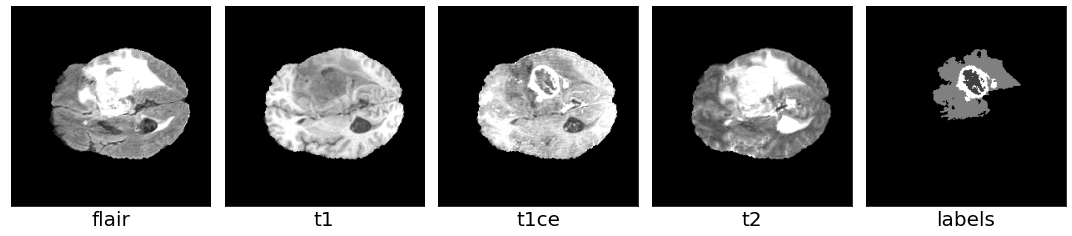

In [8]:
input_img = [tst_npy[70,:,:,i] for i in range(tst_npy.shape[-1])]
caption = ["flair", "t1", "t1ce", "t2", "labels"]
plot_comparison(input_img, caption, n_col = len(caption), figsize=(15,15))

---

# Stack Images 


Remove slices that does not contain brain tissue images while stacking all the images 

In [2]:
def threeD_to_twoD(save_dir, input_path):
    '''
    Stack all the images according to slices of a patient to create a 2D image stacks
    
    @param save_dir: The directory where the images need to be save
    @param input_path: The path where pre-processed .npy file is stored 
    @param img_channel: Image channel from input data
    '''
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for brain_tumour in sorted(os.listdir(input_path)): #HGG/LGG
        #create folder for HGG or LGG
        #only for Training folder since HGG/LGG are not available
        #for validation dataset
        #Due to lack of RAM, split HGG into 293//50=6 parts for stacking
        #max save array =>[150*155,240,240,5] (doesn't exceed 16GB RAM)
        merge_path_00 = os.path.join(input_path+brain_tumour+"/")
        #list for each patient*.npy
        patients = sorted(os.listdir(merge_path_00))
        n_patients = len(patients)
        print(n_patients)
        print(brain_tumour)
        if brain_tumour=='HGG':
            #0~49
            np_stack00 = []
            for idx in range(50):
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}01_stack.npy'.format(brain_tumour), np.array(np_stack00))
            print('Done 01!')
            #50~99
            np_stack00 = 0 #flush RAM
            np_stack00 = []
            for idx in range(50,100): #>=100, <200
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}02_stack.npy'.format(brain_tumour), np.array(np_stack00))
            #100~149
            np_stack00 = 0 #flush RAM
            np_stack00 = []
            for idx in range(100,150): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]):
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}03_stack.npy'.format(brain_tumour), np.array(np_stack00))
            #150~199
            np_stack00 = 0 #flush RAM
            np_stack00 = []
            for idx in range(150,200): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}04_stack.npy'.format(brain_tumour), np.array(np_stack00))
            #200~249
            np_stack00 = 0 #flush RAM
            np_stack00 = []
            for idx in range(200,250): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}05_stack.npy'.format(brain_tumour), np.array(np_stack00))
            # Remainder 250~293
            np_stack00 = 0 #flush RAM
            np_stack00 = []
            for idx in range(250,n_patients):
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}06_stack.npy'.format(brain_tumour), np.array(np_stack00))

        else: #LGG
            np_stack00 = 0
            np_stack00 = []
            for idx in range(int(n_patients/2)): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}01_stack.npy'.format(brain_tumour), np.array(np_stack00))
            #
            np_stack00 = 0
            np_stack00 = []
            for idx in range(int(n_patients/2),n_patients): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                        continue
                    else:
                        np_stack00.append(med_img[i])
            np_stack00 = tf.convert_to_tensor(np_stack00)
            np.save(save_dir+'{}02_stack.npy'.format(brain_tumour), np.array(np_stack00))

In [3]:
input_path = "/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/Training_pre/"
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack03/"
patients = sorted(os.listdir(input_path))
n_patients = len(patients)
n = 35
stacks = n_patients//n
remainder = n_patients%n
print(stacks)
print(remainder)

10
19


In [6]:
def threeD_to_twoD02(save_dir,input_path,n):
    patients = sorted(os.listdir(input_path))
    n_patients = len(patients)
    stacks = n_patients//n
    remainder = n_patients%n
    for i in range(stacks+1):
        np_stack00 = 0 #flush ram 
        np_stack00 = []
        #divisible stack
        if i<=stacks:
            n_end = n*(i+1)
        #reaminder
        else:
            n_end = n*i + remainder
        #debugger  
        print("i: {} with n_end:{}".format(i,n_end))
        
        for idx in range(n*i,n_end):
            merge_path_01 = os.path.join(input_path+patients[idx])
            med_img = np.load(merge_path_01).astype(np.float32)
            for i in range(med_img.shape[0]): #first dimension is the number of slices
                if (np.max(med_img[i,:,:,0])==np.min(med_img[i,:,:,0])):#remove empty slices
                    continue
                else:
                    np_stack00.append(med_img[i])
        np_stack00 = tf.convert_to_tensor(np_stack00)
        np.save(save_dir+'stack_{}.npy'.format(i), np.array(np_stack00))
    

In [ ]:
input_path = "/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/Training_pre/"
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack03/"

threeD_to_twoD02(save_dir, input_path, n=30)

i: 0 with n_end:35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


## Sanity Check

In [2]:
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack03"

for npy in sorted(os.listdir(stack_npy)):
    merge_path = os.path.join(stack_npy, npy)
    tst_npy = 0
    tst_npy = np.load(merge_path)
    print(tst_npy.shape)

(7028, 240, 240, 5)
(6984, 240, 240, 5)
(6923, 240, 240, 5)
(6879, 240, 240, 5)
(6837, 240, 240, 5)
(5770, 240, 240, 5)
(5184, 240, 240, 5)
(5239, 240, 240, 5)


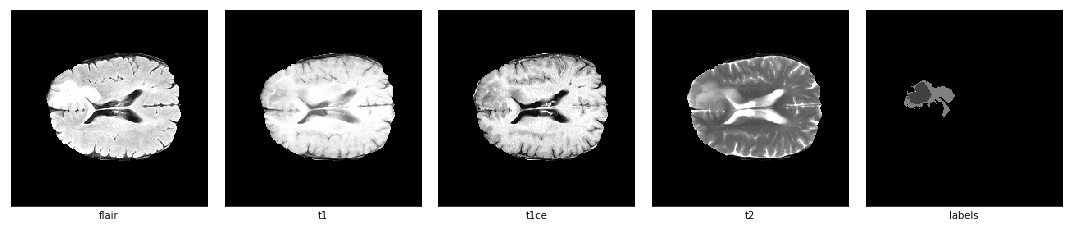

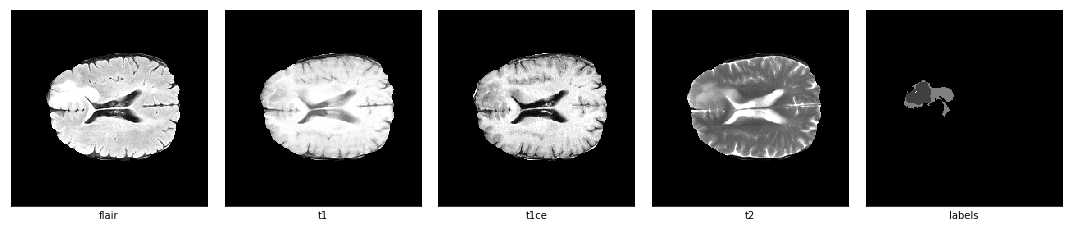

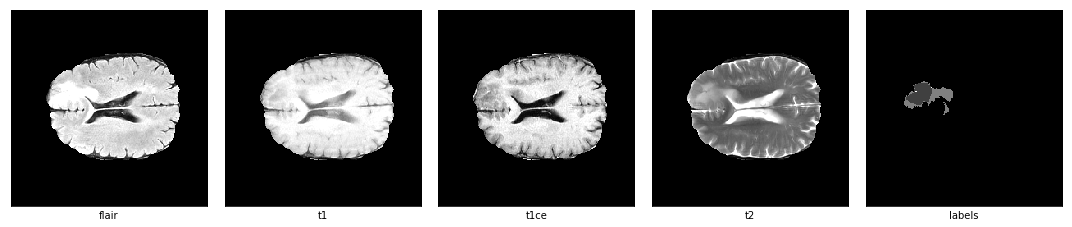

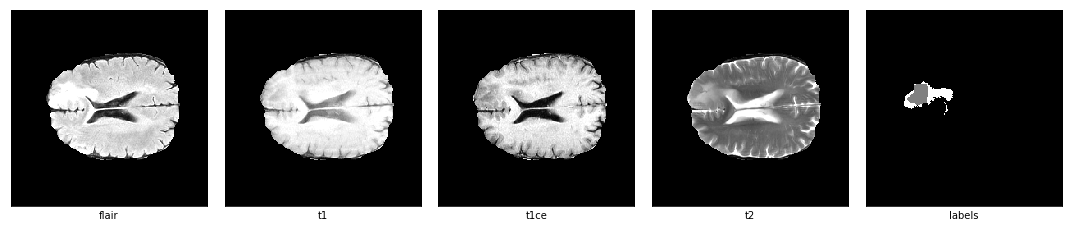

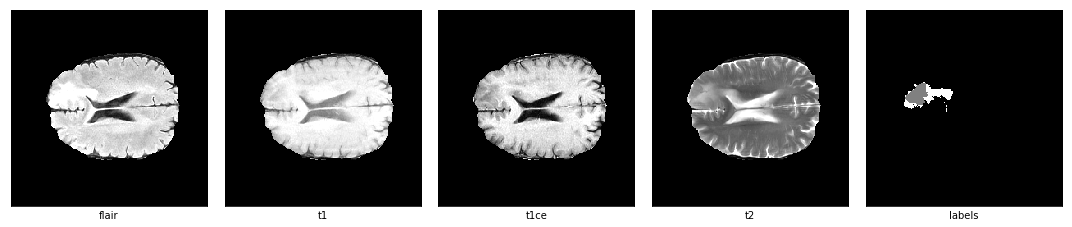

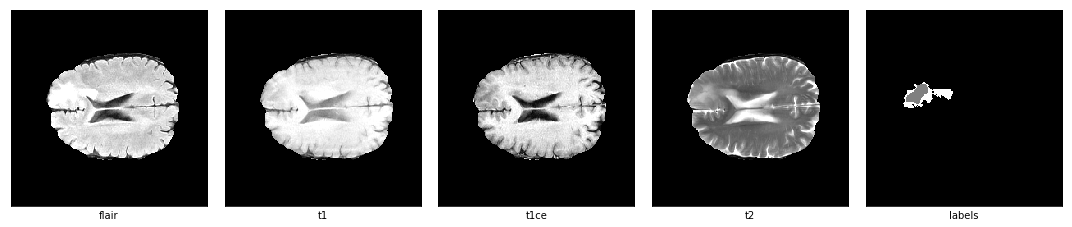

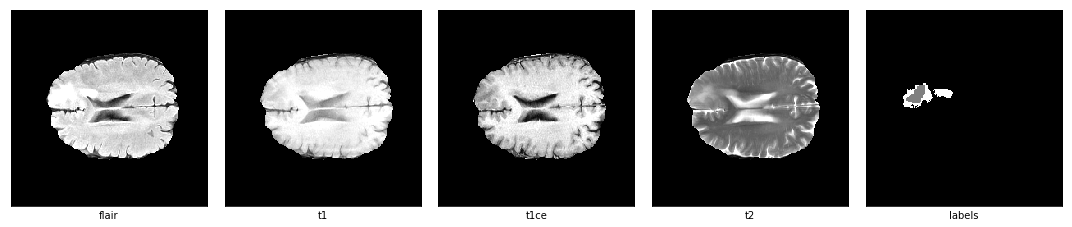

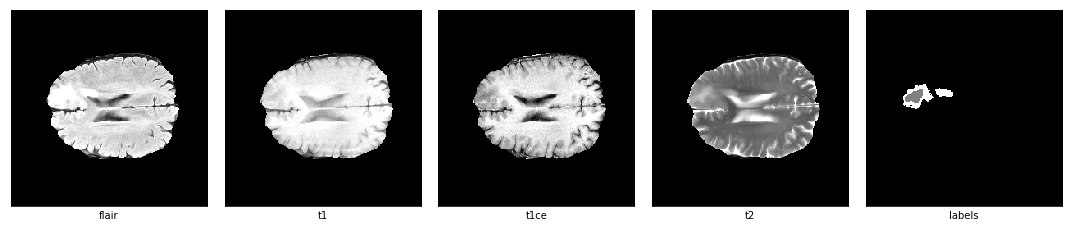

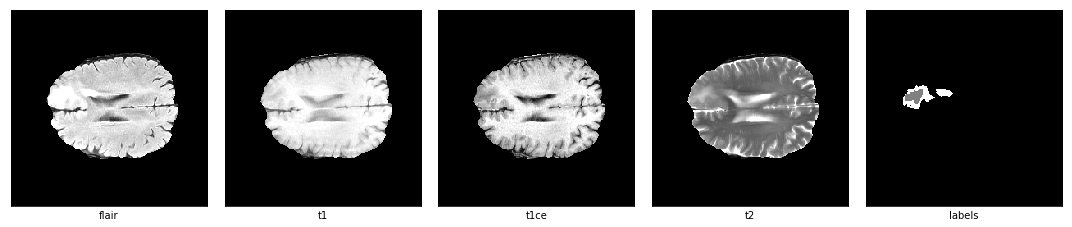

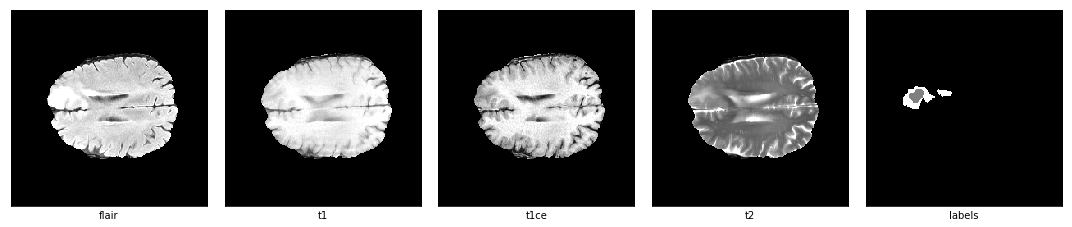

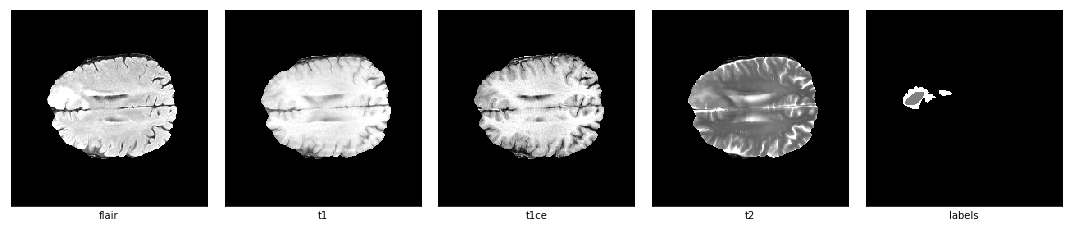

In [25]:
for j in range(80,91):
    input_img = [tst_npy[j,:,:,i] for i in range(tst_npy.shape[-1])]
    caption = ["flair", "t1", "t1ce", "t2", "labels"]
    plot_comparison(input_img, caption, n_col = len(caption), figsize=(15,15))

---

# TF_Records

In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image):
    '''
    Adding image and label info to TFRecords dataset
    '''
    feature = {
        'image': _bytes_feature(image)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecords(tfrecord_dir, image_paths):
    '''
    write TFRecords to appointed directory 
    '''
    with tf.io.TFRecordWriter(tfrecord_dir) as writer:
        for image in image_paths:
            img_bytes = tf.io.serialize_tensor(image)
            example = serialize_example(img_bytes)
            writer.write(example)
            
def read_tfrecord(serialized_example):
    '''
    read TFRecords from appointed directory 
    '''
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.parse_tensor(example['image'], out_type = float)    
    return image

def parse_tfrecord(tf_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tf_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [3]:
tfrecord_folder = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords05/'
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack05/"
#zip stack images with labels
for stack in sorted(os.listdir(save_dir)): #HGG/LGG
    merge_path_01 = os.path.join(save_dir,stack)
    print(stack)
    if not os.path.exists(tfrecord_folder):
        os.makedirs(tfrecord_folder)
        
    imgs = 0
    imgs = np.load(merge_path_01)
    save_name = stack.split(".")[0]
    tfrecord_dir = tfrecord_folder + save_name +'.tfrecords'
    write_tfrecords(tfrecord_dir, imgs)



stack_0.npy
stack_1.npy
stack_10.npy
stack_11.npy
stack_12.npy
stack_2.npy
stack_3.npy
stack_4.npy
stack_5.npy
stack_6.npy
stack_7.npy
stack_8.npy
stack_9.npy


In [5]:
#sanity check
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/'
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16

for tf_re in sorted(os.listdir(tfrecords_read_dir)):
    tf_dir = os.path.join(tfrecords_read_dir+tf_re)
    dataset = parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    imgs = next(iter(dataset))
    img = imgs[:,:,:,:4]  
    label = imgs[:,:,:,-1]
    break

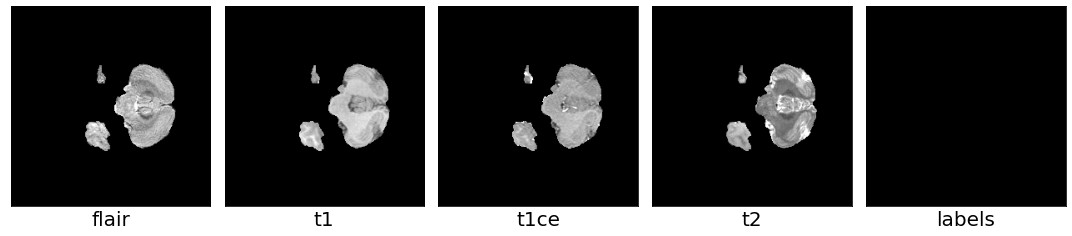

In [6]:
idx = 12
input_img = [img[idx,:,:,i] for i in range(img.shape[-1])]
input_img.append(label[idx])
caption = ["flair", "t1", "t1ce", "t2", "labels"]
plot_comparison(input_img, caption, n_col = len(caption), figsize=(15,15))

---

# Data Augmentation Generator 

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20.0,
    zoom_range=0.1, 
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last"
)

In [4]:
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack03"

for npy in sorted(os.listdir(stack_npy)):
    merge_path = os.path.join(stack_npy, npy)
    tst_npy = 0
    tst_npy = np.load(merge_path)
    break

In [5]:
for imgs in datagen.flow(tst_npy, batch_size=16):
    img = imgs[:,:,:,:4]
    label = imgs[:,:,:,-1]
    break

/home/kevinteng/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (7028, 240, 240, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


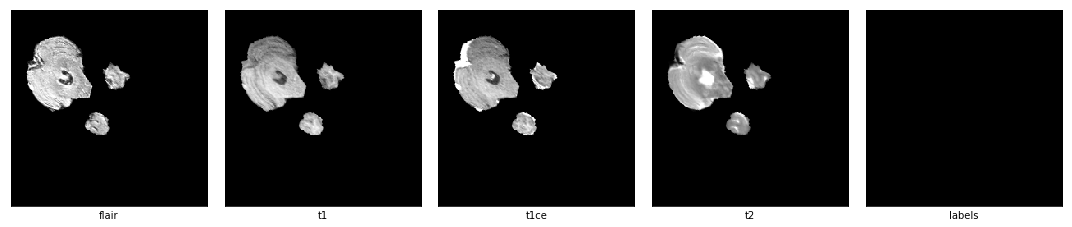

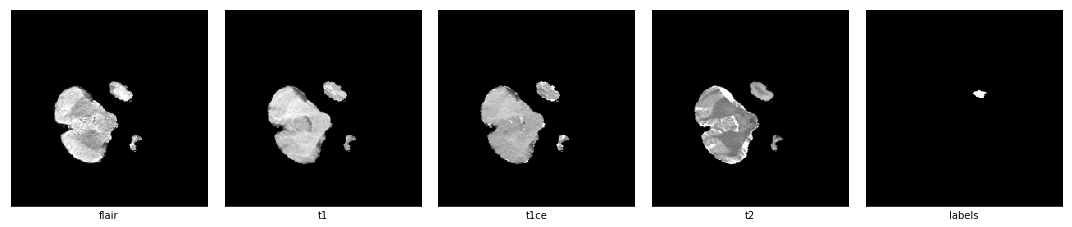

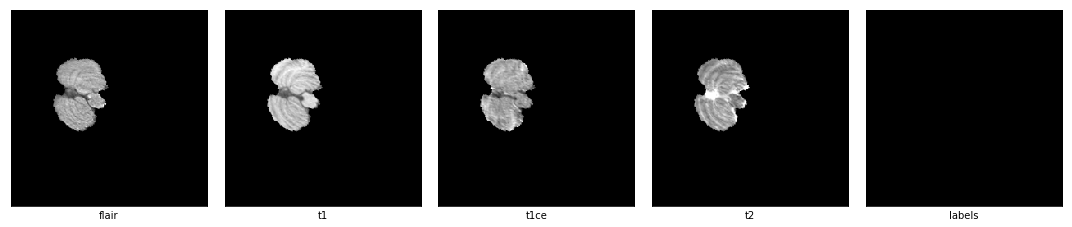

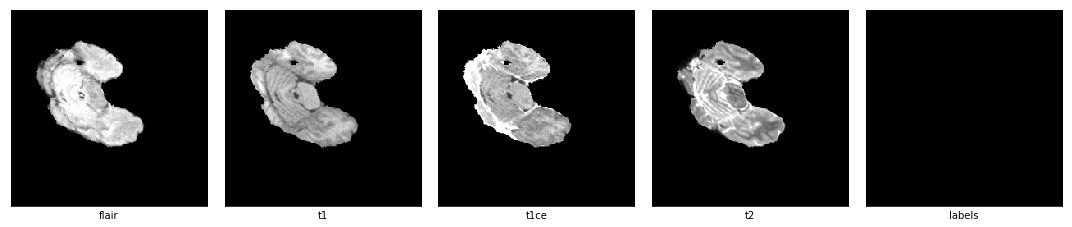

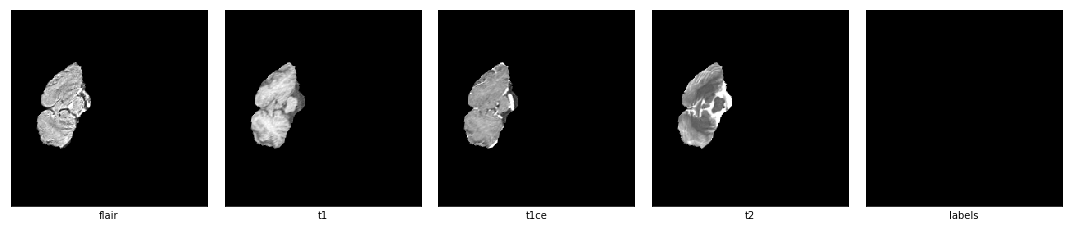

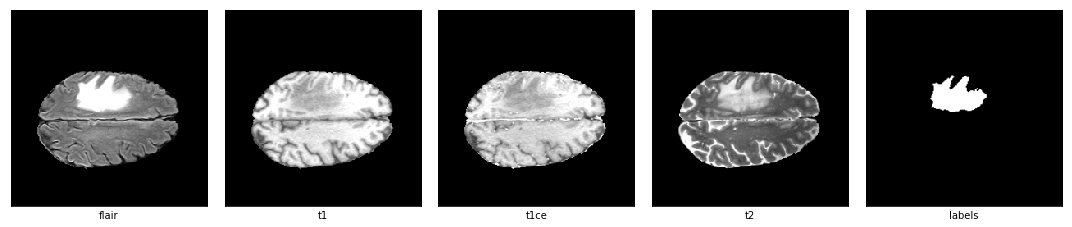

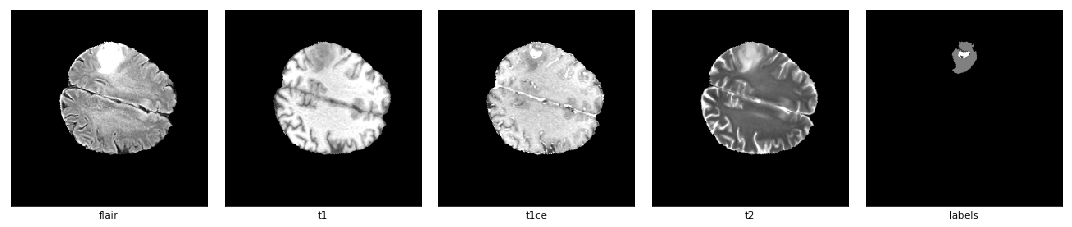

In [9]:
for idx in range(5,12):
    input_img = [img[idx,:,:,i] for i in range(img.shape[-1])]
    input_img.append(label[idx])
    caption = ["flair", "t1", "t1ce", "t2", "labels"]
    plot_comparison(input_img, caption, n_col = len(caption), figsize=(15,15))